# 시계열 데이터
**시계열 데이터**는 일정 간격으로 측정하여 얻은 데이터를 말함.
가장 일반적으로 현시점의 시계열 데이터 다음에 일어날 패턴을 예측하는 작업을 함.

## 시계열 데이터 작업
- 분류 : 하나 이상의 범주형 레이블을 시계열에 부여해 분류를 진행(ex.웹사이트의 방문자 추이에 대한 데이터로 봇인지 사람인지 분류)
- 이벤트 감지 : 연속된 데이터 스트림에서 특정 이벤트 식별(ex.핫워드 감지 모델이 오디오 스트림을 모니터링하는 중 특정 단어 감지)
- 이상치 탐지 : 연속된 데이터 스트림에서 발생하는 비정상적인 패턴을 감지(ex. 네트워크에서 비정상적 활동이 감지될 경우 외부공격으로 식별)

## 온도예측 문제
### 기상 관측소 데이터
데이터 설명 : 독일 예나시에 있는 막스 플랑크 생물지구과학연구소에서 수년간에 걸쳐 온도,기온,습도,풍향 등 14개의 수치를 10분마다 관측한 데이터(2009~2016년)

In [1]:
!pip install wget

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import wget,zipfile

In [3]:
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
wget.download(url)

100% [........................................................................] 13565642 / 13565642

'jena_climate_2009_2016.csv (1).zip'

In [4]:
zipfile.ZipFile('jena_climate_2009_2016.csv.zip').extractall('./data/series')

### 총 420451개 데이터

In [5]:
import os
fname=os.path.join('data/series/jena_climate_2009_2016.csv')

with open(fname) as f:
    data=f.read()

해당 데이터는 0번째에 컬럼명,1번째 이후부터 데이터가 들어있음

In [6]:
lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### 데이터 파싱

In [7]:
import numpy as np

temp=np.zeros((len(lines),))
raw_d=np.zeros((len(lines),len(header)-1))

In [8]:
temp.shape

(420451,)

In [9]:
raw_d.shape

(420451, 14)

In [10]:
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    temp[i]=values[1] # 두번째 열을 temp에 저장
    raw_d[i,:]=values[:] # 모든 열을 raw_d에 저장

In [11]:
temp

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [12]:
import matplotlib.pyplot as plt

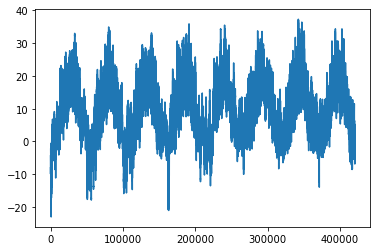

In [13]:
plt.plot(range(len(temp)),temp)

처음 10간의 온도 출력(매 10분마다 10일간 기록된 1440개(6x24x10)데이터)

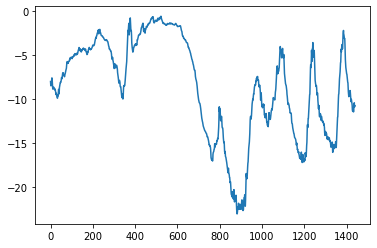

In [14]:
plt.plot(range(1440),temp[:1440])
# 영하가 지속되는 것으로 보아 겨울이고 마지막 4일에는 데이터에 패턴이 존재함

### 데이터 분할

In [15]:
tr_sample=int(len(raw_d)*0.5)
val_sample=int(len(raw_d)*0.25)
te_sample=len(raw_d)-tr_sample-val_sample

print("Train_date : {0}".format(tr_sample))
print("Val_date : {0}".format(val_sample))
print("Test_date : {0}".format(te_sample))

Train_date : 210225
Val_date : 105112
Test_date : 105114


### 데이터 준비

In [16]:
# 데이터 정규화
m=raw_d[:tr_sample].mean(axis=0)
std=raw_d[:tr_sample].std(axis=0)
raw_std=(raw_d-m)/std
raw_std

array([[ 0.91365151, -1.92064015, -1.97449272, ..., -0.73016651,
        -0.77935289, -0.28119316],
       [ 0.91953033, -1.96510495, -2.01848295, ..., -0.93230685,
        -0.88696976, -0.46989368],
       [ 0.91482727, -1.97650618, -2.0297625 , ..., -1.27790162,
        -1.26147647, -0.05638329],
       ...,
       [ 1.30165361, -1.36654038, -1.45450563, ..., -0.69756323,
        -0.67173602,  0.45147737],
       [ 1.30047784, -1.48853354, -1.57519677, ..., -0.43021634,
        -0.60286122,  0.57494808],
       [ 1.30165361, -1.5558008 , -1.64061814, ..., -0.59975339,
        -0.68895472,  0.09853751]])

#### timeseries_dataset_from_array() 함수를 이용해 홀드아웃
매개변수
- sampling_rate : 6으로 지정하면 한시간에 1개의 데이터 포인트 샘플링
- sequence_length : 120으로 지정하면 이전 120시간(5일)전 까지의 데이터 사용
- delay = sampling_rate * (sequence_length + 24 -1) : 시퀀스의 타겟이 끝에서 24시간 후의 온도
    
    (시퀀스의 타겟 : data[n]이면 시퀀스의 타겟은 data[n+sequence_length])

In [17]:
from tensorflow import keras

In [18]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_std[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=tr_sample)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_std[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=tr_sample,
    end_index=tr_sample + val_sample)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_std[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=tr_sample + val_sample)

## 기본적인 모델 생성

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
model=keras.Sequential()
model.add(keras.Input(shape=(sequence_length,raw_std.shape[-1])))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16,activation='relu'))

In [38]:
callbacks=[keras.callbacks.ModelCheckpoint('jena_dense.keras',save_best_only=True)]

In [39]:
model.compile(optimizer='rmsprop',loss='mse',metrics='mae')
history=model.fit(train_dataset,epochs=10,
                 validation_data=val_dataset,
                 callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 14.7466 - mae: 2.8803 - val_loss: 10.6193 - val_mae: 2.5459
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 14.3890 - mae: 2.8339 - val_loss: 10.4644 - val_mae: 2.5379
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 14.2428 - mae: 2.8126 - val_loss: 11.2535 - val_mae: 2.6580
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 14.1955 - mae: 2.8061 - val_loss: 10.2286 - val_mae: 2.5129
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 14.1604 - mae: 2.8001 - val_loss: 9.9447 - val_mae: 2.4655
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 14.1549 - mae: 2.7990 - val_loss: 10.5254 - val_mae: 2.5490
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 14.1581 - mae: 2.7990 - val_loss: 10.1338 - val_mae: 2.4912
Epoch 8/10
819/819 [=============================

In [41]:
model=keras.models.load_model('jena_dense.keras')
print('테스트 MAE {0}'.format(model.evaluate(test_dataset)[1]))

405/405 [==============================] - 4s 9ms/step - loss: 10.3946 - mae: 2.5380
테스트 MAE 2.538005828857422


## Train and Valid 그래프

In [27]:
import matplotlib.pyplot as plt

In [42]:
loss,val_loss=(history.history['mae'],history.history['val_mae'])

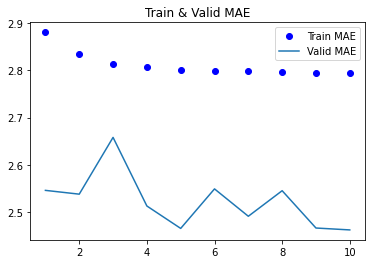

In [43]:
plt.figure()
plt.plot(range(1,len(loss)+1),loss,'bo',label='Train MAE')
plt.plot(range(1,len(loss)+1),val_loss,label='Valid MAE')
plt.title('Train & Valid MAE')
plt.legend()
plt.show()
# 과적합

## 합성곱 모델 생성

In [36]:
model2=keras.Sequential()
model2.add(keras.Input(shape=(sequence_length,raw_std.shape[-1])))
model2.add(keras.layers.Conv1D(8,24,activation='relu'))
model2.add(keras.layers.MaxPooling1D(2))
model2.add(keras.layers.Conv1D(8,12,activation='relu'))
model2.add(keras.layers.MaxPooling1D(2))
model2.add(keras.layers.Conv1D(8,6,activation='relu'))
model2.add(keras.layers.GlobalAveragePooling1D())
model2.add(keras.layers.Dense(1))

In [37]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392       
                                                                 
 global_average_pooling1d (G  (None, 8)               

In [44]:
callbacks=[keras.callbacks.ModelCheckpoint('jena_conv.keras',save_best_only=True)]

model2.compile(optimizer='rmsprop',loss='mse',metrics='mae')
history2=model2.fit(train_dataset,epochs=10,
                 validation_data=val_dataset,
                 callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 39s 46ms/step - loss: 22.9987 - mae: 3.7607 - val_loss: 15.3074 - val_mae: 3.1080
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.5990 - mae: 3.1267 - val_loss: 14.7407 - val_mae: 3.0454
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 13.9301 - mae: 2.9489 - val_loss: 15.8555 - val_mae: 3.1812
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 13.0565 - mae: 2.8556 - val_loss: 14.7383 - val_mae: 3.0174
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 12.4586 - mae: 2.7911 - val_loss: 17.6830 - val_mae: 3.3095
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 11.9617 - mae: 2.7339 - val_loss: 15.2580 - val_mae: 3.0940
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 11.5537 - mae: 2.6857 - val_loss: 15.2645 - val_mae: 3.0776
Epoch 8/10
819/819 [============================

In [46]:
model2=keras.models.load_model('jena_conv.keras')
print('Conv 테스트 MAE {0}'.format(model2.evaluate(test_dataset)[1]))

405/405 [==============================] - 6s 15ms/step - loss: 17.1268 - mae: 3.2642
Conv 테스트 MAE 3.264207363128662


In [47]:
loss2,val_loss2=(history2.history['mae'],history2.history['val_mae'])

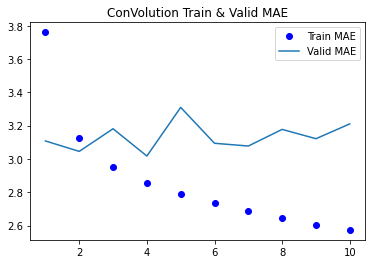

In [48]:
plt.figure()
plt.plot(range(1,len(loss2)+1),loss2,'bo',label='Train MAE')
plt.plot(range(1,len(loss2)+1),val_loss2,label='Valid MAE')
plt.title('ConVolution Train & Valid MAE')
plt.legend()
plt.show()

합성곱 신경망이 일반 신경망 모델보다 성능이 떨어짐.  
이유 : 시계열 데이터는 합성곱 모델에서 평행 이동 불변성의 가정을 많이 따르지 않아서 성능이 더 안좋은 것임. 데이터는 일별로 패턴이 존재하지만 일별 데이터 내에서 아침은 저녁,한밤중의 데이터와 성질이 다르기 때문
또한, 시계열 데이터는 순서가 중요한 반면 1D 합성곱 모델은 Maxpooling과GlobalAverage 층에서 순서 정보가 많이 사라지기 때문에 합성곱 모델은 성능이 저하되는 것임.

## 순환신경망 모델 생성(LSTM(Long-Shorts-Term Memory))
**LSTM** : 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완하여 장/단기 기억을 가능하게 설계한 신경망의 구조

### RNN과 LSTM의 함수 차이

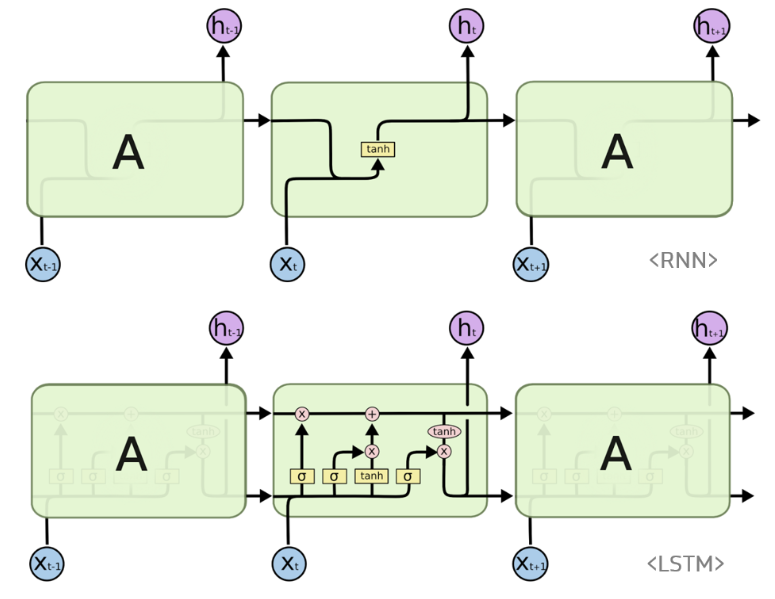

In [49]:
model3=keras.Sequential()
model3.add(keras.Input(shape=(sequence_length,raw_std.shape[-1])))
model3.add(keras.layers.LSTM(16))
model3.add(keras.layers.Dense(1))

In [50]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [52]:
callbacks=[keras.callbacks.ModelCheckpoint('jena_lstm.keras',save_best_only=True)]

model3.compile(optimizer='rmsprop',loss='mse',metrics='mae')
history3=model3.fit(train_dataset,epochs=10,
                 validation_data=val_dataset,
                 callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 61s 70ms/step - loss: 38.7430 - mae: 4.5275 - val_loss: 11.9623 - val_mae: 2.6471
Epoch 2/10
819/819 [==============================] - 65s 79ms/step - loss: 10.8324 - mae: 2.5657 - val_loss: 9.4309 - val_mae: 2.4028
Epoch 3/10
819/819 [==============================] - 57s 70ms/step - loss: 9.7556 - mae: 2.4369 - val_loss: 9.4694 - val_mae: 2.4025
Epoch 4/10
819/819 [==============================] - 62s 76ms/step - loss: 9.3244 - mae: 2.3763 - val_loss: 9.4613 - val_mae: 2.4031
Epoch 5/10
819/819 [==============================] - 60s 73ms/step - loss: 9.0004 - mae: 2.3339 - val_loss: 9.5569 - val_mae: 2.4051
Epoch 6/10
819/819 [==============================] - 61s 74ms/step - loss: 8.7278 - mae: 2.3012 - val_loss: 9.6194 - val_mae: 2.4252
Epoch 7/10
819/819 [==============================] - 58s 71ms/step - loss: 8.4426 - mae: 2.2670 - val_loss: 9.8524 - val_mae: 2.4479
Epoch 8/10
819/819 [==============================] - 62s 7

In [53]:
model3=keras.models.load_model('jena_lstm.keras')
print('LSTM 테스트 MAE {0}'.format(model3.evaluate(test_dataset)[1]))

405/405 [==============================] - 14s 32ms/step - loss: 10.8010 - mae: 2.5936
LSTM 테스트 MAE 2.5935797691345215


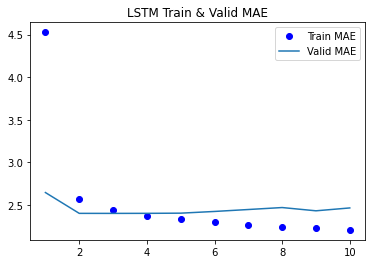

In [54]:
loss3,val_loss3=(history3.history['mae'],history3.history['val_mae'])

plt.figure()
plt.plot(range(1,len(loss3)+1),loss3,'bo',label='Train MAE')
plt.plot(range(1,len(loss3)+1),val_loss3,label='Valid MAE')
plt.title('LSTM Train & Valid MAE')
plt.legend()
plt.show()

간단한 LSTM모델만으로 완전연결 신경망과 합성곱 신경망에 비해 성능이 개선되었다.  
가장 낮은 검증 MAE가 2.4까지 내려감(완전연결 신경망과 큰차이는 아니지만 성능이 약간 개선되었음)